In [1]:
import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchsummary import summary
import cv2

In [2]:
data_size = 100

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class CXRDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(label_file)[:data_size]
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        
        img_name = row['ImageID']
        labels = row.iloc[:14].values.astype(int)
        
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels, dtype=torch.int64)

In [3]:
label_file = "/Users/james/Documents/dataset/MIMIC-CXR/data_selection-241201.csv"
image_dir = "/Users/james/Documents/dataset/MIMIC-CXR/images_resized"

dataset = CXRDataset(image_dir=image_dir, label_file=label_file, transform=transform)

batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [39]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        
        # U-Net Encoder: ResNet Backbone
        self.base_model = models.resnet34(pretrained=True)
        self.conv1 = self.base_model.conv1
        self.bn1 = self.base_model.bn1
        self.relu = self.base_model.relu
        self.maxpool = self.base_model.maxpool
        self.layer1 = self.base_model.layer1
        self.layer2 = self.base_model.layer2
        self.layer3 = self.base_model.layer3
        self.layer4 = self.base_model.layer4
        
        # U-Net Decoder
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(512, 256)  # 256 + 256 channels
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)  # 128 + 128 channels
        
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(128, 64)   # 64 + 64 channels
        
        # Final U-Net Output (for segmentation analysis, optional)
        self.seg_output = nn.Conv2d(64, num_classes, kernel_size=1)
        
        # Modified Classification Head
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 + 64, num_classes)  # Adjusted input size
        
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        x1 = self.relu(self.bn1(self.conv1(x)))   # [batch, 64, 112, 112]
        x2 = self.maxpool(x1)                     # [batch, 64, 56, 56]
        x3 = self.layer1(x2)                      # [batch, 64, 56, 56]
        x4 = self.layer2(x3)                      # [batch, 128, 28, 28]
        x5 = self.layer3(x4)                      # [batch, 256, 14, 14]
        x6 = self.layer4(x5)                      # [batch, 512, 7, 7]

        # Decoder
        up1 = self.up1(x6)                        # [batch, 256, 14, 14]
        dec1 = self.dec1(torch.cat([up1, x5], dim=1))  # [batch, 512, 14, 14]

        up2 = self.up2(dec1)                      # [batch, 128, 28, 28]
        dec2 = self.dec2(torch.cat([up2, x4], dim=1))  # [batch, 256, 28, 28]

        up3 = self.up3(dec2)                      # [batch, 64, 56, 56]
        dec3 = self.dec3(torch.cat([up3, x3], dim=1))  # [batch, 128, 56, 56]

        # Segmentation Output
        seg_output = self.seg_output(dec3)        # [batch, num_classes, 56, 56]

        # Combine features from encoder and decoder
        gap_x6 = self.gap(x6).view(x6.size(0), -1)      # [batch, 512]
        gap_dec3 = self.gap(dec3).view(dec3.size(0), -1)  # [batch, 64]
        combined_features = torch.cat([gap_x6, gap_dec3], dim=1)  # [batch, 576]

        # Classification Head
        class_output = self.fc(combined_features)   # [batch, num_classes]

        return class_output, seg_output

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channels = 3
out_channels = 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels, out_channels).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

In [41]:
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    |    └─BasicBlock: 3-3              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-4              230,144
|    |    └─BasicBlock: 3-5              295,424
|    |    └─BasicBlock: 3-6              295,424
|    |    └─BasicBlock: 3-7              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-8              919,040
|    |    └─BasicBlock: 3-9              1,180,672
|    |    └─BasicBlock: 3-10             1,180,672
|    |    └─BasicBlock: 3-11             1,180,672
|    |    └─BasicBlock: 3-12             1,180,672
| 

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    |    └─BasicBlock: 3-3              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-4              230,144
|    |    └─BasicBlock: 3-5              295,424
|    |    └─BasicBlock: 3-6              295,424
|    |    └─BasicBlock: 3-7              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-8              919,040
|    |    └─BasicBlock: 3-9              1,180,672
|    |    └─BasicBlock: 3-10             1,180,672
|    |    └─BasicBlock: 3-11             1,180,672
|    |    └─BasicBlock: 3-12             1,180,672
| 

In [42]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).float()

            class_output, seg_output = model(images)

            loss = criterion(class_output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.4f}")

In [43]:
train_model(model, dataloader, criterion, optimizer, device, num_epochs=10)

Epoch 1/10: 100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch 1, Loss: 0.6569


Epoch 2/10: 100%|██████████| 7/7 [00:15<00:00,  2.15s/it]


Epoch 2, Loss: 0.4219


Epoch 3/10: 100%|██████████| 7/7 [00:15<00:00,  2.28s/it]


Epoch 3, Loss: 0.2631


Epoch 4/10: 100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


Epoch 4, Loss: 0.1481


Epoch 5/10: 100%|██████████| 7/7 [00:15<00:00,  2.28s/it]


Epoch 5, Loss: 0.1066


Epoch 6/10: 100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


Epoch 6, Loss: 0.0777


Epoch 7/10: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it]


Epoch 7, Loss: 0.0615


Epoch 8/10: 100%|██████████| 7/7 [00:16<00:00,  2.29s/it]


Epoch 8, Loss: 0.0434


Epoch 9/10: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it]


Epoch 9, Loss: 0.0366


Epoch 10/10: 100%|██████████| 7/7 [00:16<00:00,  2.38s/it]

Epoch 10, Loss: 0.0283


In [44]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, "checkpoint1203.pth")

In [45]:
checkpoint = torch.load("checkpoint1203.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

/var/folders/vx/ymwszs4d6ggck5zzyjky5ldm0000gn/T/ipykernel_19530/1015621629.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint1203.pth")

In [46]:
def predict_and_compare(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Model prediction
            class_output, seg_output = model(images)  # Unpack the outputs
            preds = torch.sigmoid(class_output) > 0.5  # Apply sigmoid to class_output

            # Save results
            predictions.append(preds.cpu())
            true_labels.append(labels.cpu())

    # Concatenate tensors
    predictions = torch.cat(predictions, dim=0)
    true_labels = torch.cat(true_labels, dim=0)

    return predictions, true_labels

In [47]:
predictions, true_labels = predict_and_compare(model, dataloader, device)

# Output the results
for i in range(len(predictions)):
    print(f"Sample {i + 1}:")
    print(f"Predicted: {predictions[i].int().numpy()}")
    print(f"True Label: {true_labels[i].numpy()}")
    print("-" * 50)

Sample 1:
Predicted: [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
True Label: [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
--------------------------------------------------
Sample 2:
Predicted: [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
True Label: [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
--------------------------------------------------
Sample 3:
Predicted: [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
True Label: [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
--------------------------------------------------
Sample 4:
Predicted: [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
True Label: [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
--------------------------------------------------
Sample 5:
Predicted: [0 1 0 0 0 0 0 0 0 1 0 0 0 0]
True Label: [0 1 0 0 0 0 0 0 0 1 0 0 0 0]
--------------------------------------------------
Sample 6:
Predicted: [0 0 0 0 0 0 0 0 0 1 0 0 0 1]
True Label: [0 0 0 0 0 0 0 0 0 1 0 0 0 1]
--------------------------------------------------
Sample 7:
Predicted: [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
True Label: [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
-------------------------------------------

In [48]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()  # Set model to evaluation mode
        self.device = next(model.parameters()).device

        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        class_output, _ = self.model(input_image)

        if target_class is None:
            # Use the class with the highest score if target_class is not specified
            target_class = torch.argmax(class_output, dim=1)

        # Zero grads
        self.model.zero_grad()

        # Ensure target_class is a 1-D tensor
        if target_class.dim() == 0:
            target_class = target_class.unsqueeze(0)

        # Compute loss for the target class
        one_hot = torch.zeros_like(class_output).to(self.device)
        one_hot.scatter_(1, target_class.unsqueeze(1), 1)

        # Backward pass
        class_output.backward(gradient=one_hot, retain_graph=True)

        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        # Compute weighted sum of activations
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)

        # Normalize the heatmap
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.cpu().squeeze().numpy()

        return cam


In [49]:
# 3. Prepare an input image
image, label = dataset[29]
image = image.unsqueeze(0).to(device)
label = label.unsqueeze(0).to(device)

# 4. Generate the Grad-CAM heatmap
positive_classes = torch.nonzero(label[0]).view(-1)
if positive_classes.numel() > 0:
    target_class = positive_classes[0]
else:
    target_class = torch.tensor(0, device=device)

print(target_class)
print(torch.tensor(3, device=device))

tensor(1)
tensor(3)


# Layer4

## Non-zero label check

In [50]:
data_idxs = [i for i in range(100)]

for data_idx in data_idxs:
    _, label = dataset[data_idx]
    label = label.unsqueeze(0).to(device)
    # Print torch.nonzero(label[0]).view(-1) in list and int
    nonzero_indices = torch.nonzero(label[0]).view(-1)
    print(f"{data_idx}: {nonzero_indices.tolist()}")


0: [8]
1: [8]
2: [8]
3: [8]
4: [8]
5: [2]
6: [8]
7: [8]
8: [9, 11]
9: [7]
10: [8]
11: [6, 7]
12: [5]
13: []
14: []
15: [6, 11]
16: [8]
17: [3]
18: [8]
19: [9]
20: [1, 3, 9]
21: [1, 9]
22: [9]
23: [8]
24: [8]
25: [8]
26: [7]
27: [3]
28: [3]
29: [1, 12, 13]
30: [8, 13]
31: [0]
32: [0]
33: [1]
34: [8, 13]
35: [8, 13]
36: [8]
37: [8]
38: [8]
39: [1, 13]
40: [1, 3, 9, 13]
41: [11]
42: [8]
43: [7]
44: [8]
45: [0]
46: [7]
47: []
48: [8]
49: [8]
50: [8]
51: [8]
52: [8]
53: [1]
54: [8]
55: [7]
56: [0]
57: [1, 3, 9, 13]
58: [3]
59: [8]
60: [8]
61: [8]
62: [8]
63: [8]
64: [0]
65: [1]
66: [8]
67: [7, 13]
68: [8]
69: [8]
70: [1, 4, 9, 12]
71: [8]
72: [8]
73: [8]
74: [8]
75: []
76: [8]
77: [0, 13]
78: [0, 9]
79: [9]
80: [8]
81: [8]
82: [9, 11]
83: [0, 3, 7, 9, 13]
84: [0, 7, 9, 13]
85: [9, 13]
86: [0, 7, 9, 13]
87: [9, 13]
88: [7, 9, 13]
89: [3, 9, 13]
90: [3, 7]
91: [7, 9, 13]
92: [0, 3, 9]
93: [9, 13]
94: []
95: [0, 9, 13]
96: [7, 9, 11]
97: [9, 13]
98: [9, 13]
99: [0, 1, 9, 13]


In [51]:
data_idxs = [5, 6, 7, 8, 9, 10] # 0-99
label_idxs = [7] # 0-13

/var/folders/vx/ymwszs4d6ggck5zzyjky5ldm0000gn/T/ipykernel_19530/952076471.py:30: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)


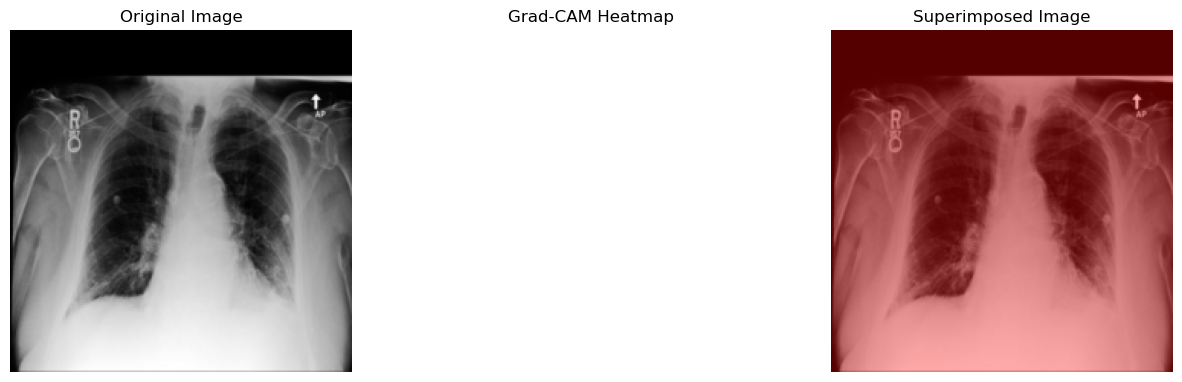

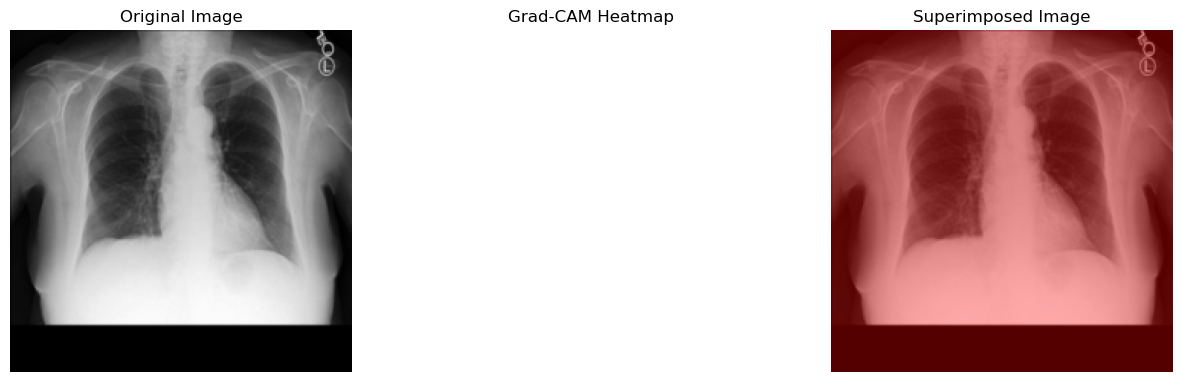

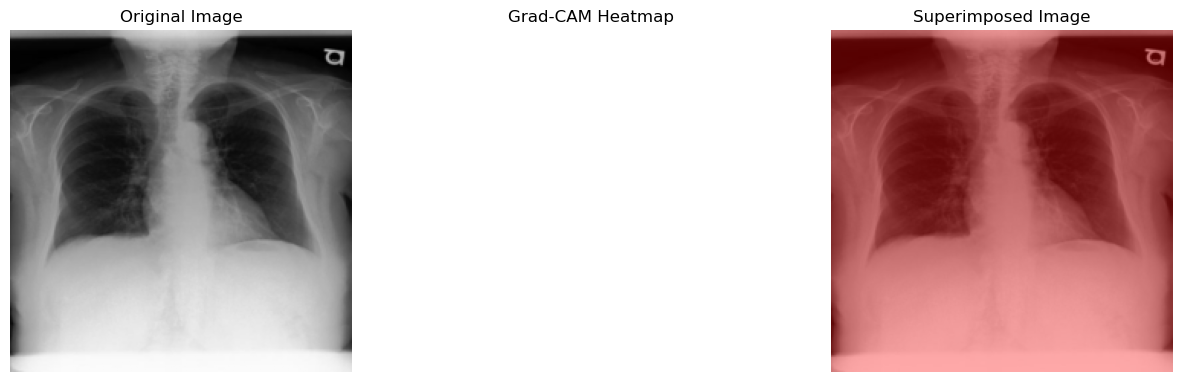

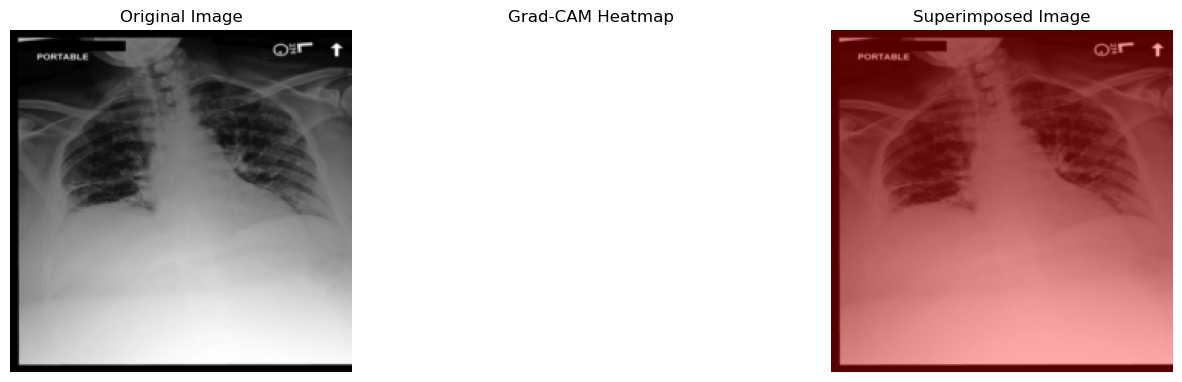

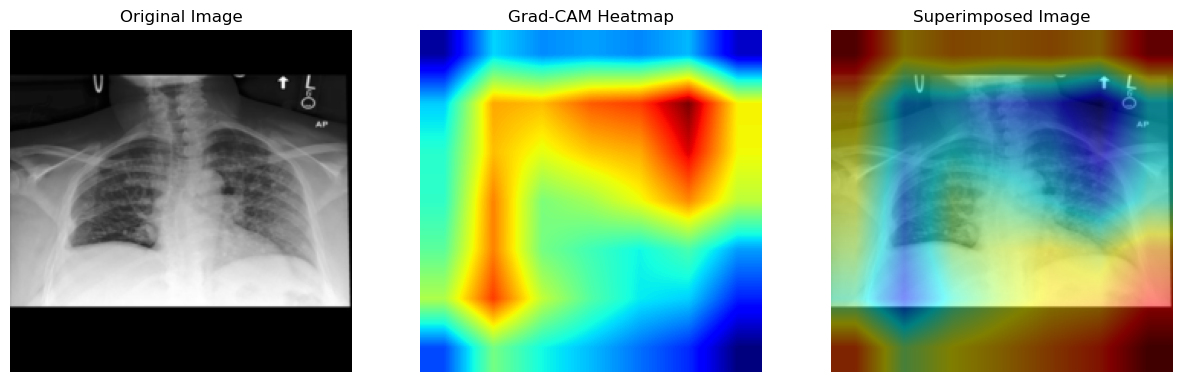

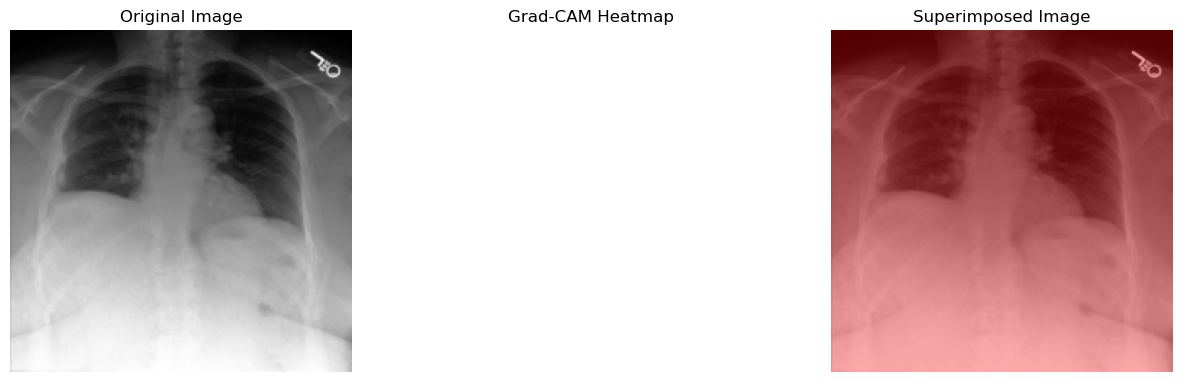

In [52]:
# 2. Initialize Grad-CAM
target_layer = model.layer4[-1]
grad_cam = GradCAM(model, target_layer)

# 3. Prepare an input image

for data_idx in data_idxs:
    image, label = dataset[data_idx]
    image = image.unsqueeze(0).to(device)
    label = label.unsqueeze(0).to(device)

    # 4. Generate the Grad-CAM heatmap
    for label_idx in label_idxs:
        # Ensure target_class is a tensor on the correct device
        target_class = torch.tensor(label_idx, device=device).to(device)

        # Generate the CAM
        cam = grad_cam.generate_cam(image, target_class=target_class)

        # 5. Visualize the heatmap (same as before)
        # Convert the image to numpy and denormalize
        img_np = image.cpu().squeeze().numpy()
        img_np = np.transpose(img_np, (1, 2, 0))
        img_np = img_np * 0.5 + 0.5  # Denormalize

        # Resize CAM to match image size
        cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))

        # Convert CAM to heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255

        # Superimpose heatmap on image
        superimposed_img = heatmap + np.float32(img_np)
        superimposed_img = superimposed_img / np.max(superimposed_img)

        # Plot the images
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(img_np)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Grad-CAM Heatmap')
        plt.imshow(cam_resized, cmap='jet')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Superimposed Image')
        plt.imshow(superimposed_img)
        plt.axis('off')

        plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/cmu24/lib/python3.10/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


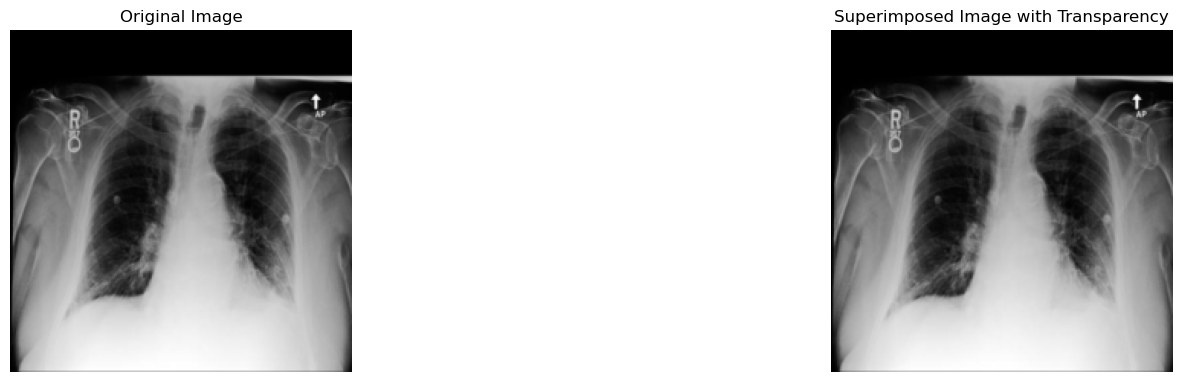

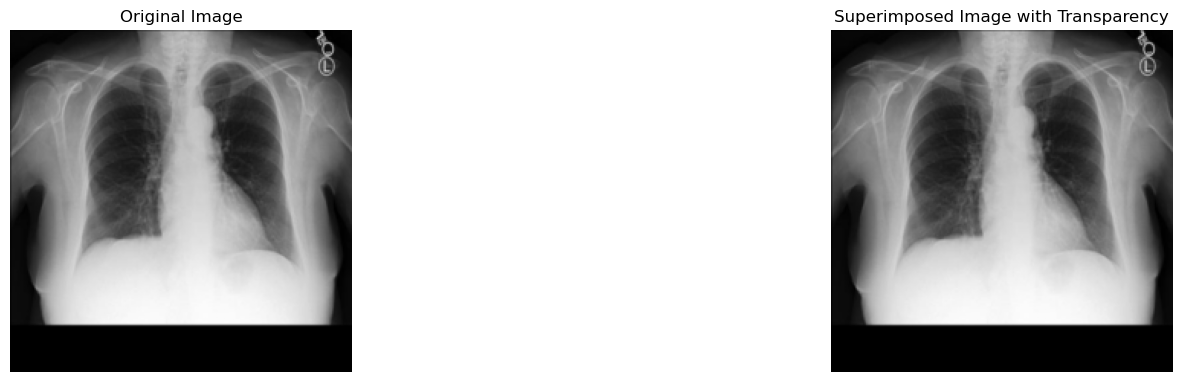

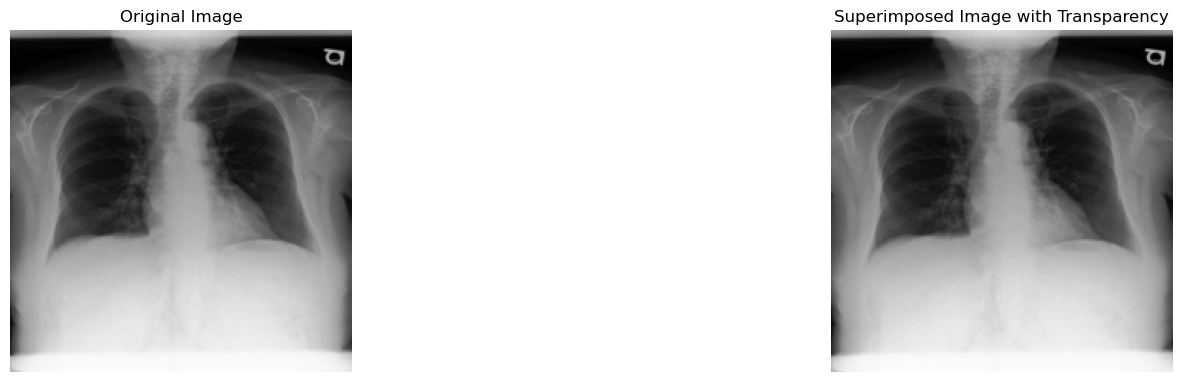

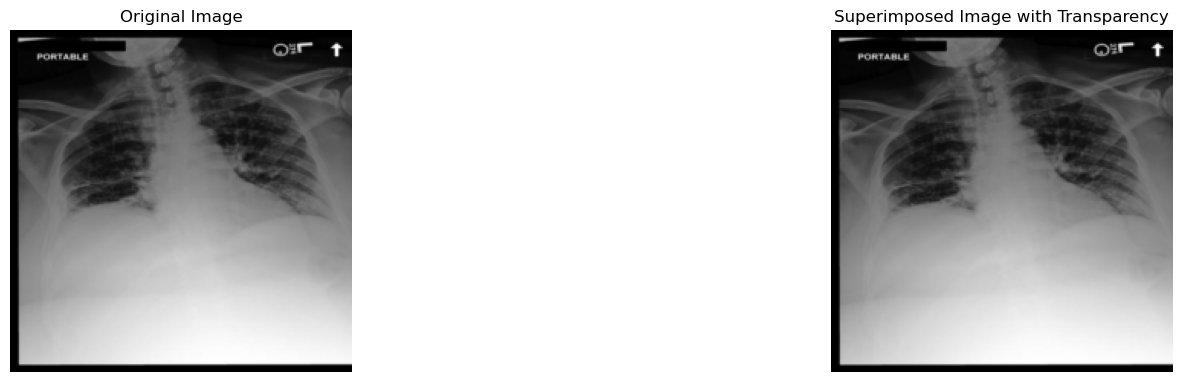

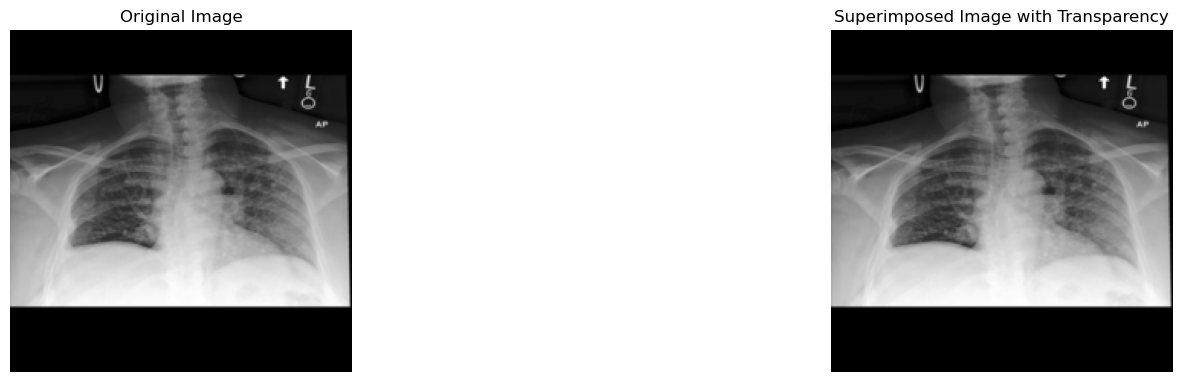

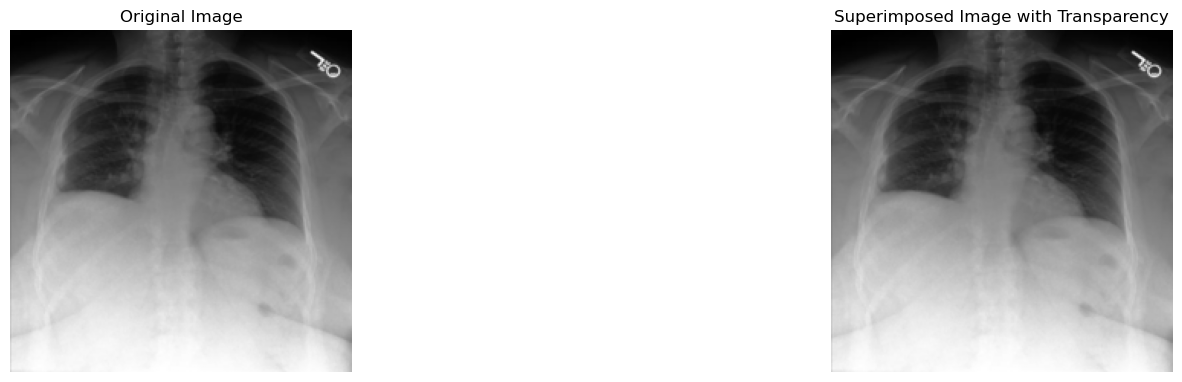

In [69]:
# 2. Initialize Grad-CAM
# target_layer = model.layer4[-1]
target_layer = model.dec3[2]


grad_cam = GradCAM(model, target_layer)

# 3. Prepare an input image
for data_idx in data_idxs:
    image, label = dataset[data_idx]
    image = image.unsqueeze(0).to(device)
    label = label.unsqueeze(0).to(device)

    # 4. Generate the Grad-CAM heatmap
    for label_idx in label_idxs:
        # Ensure target_class is a tensor on the correct device
        target_class = torch.tensor(label_idx, device=device)

        # Generate the CAM
        cam = grad_cam.generate_cam(image, target_class=target_class)

        # 5. Visualize the heatmap
        # Convert the image to numpy and denormalize
        img_np = image.cpu().squeeze().numpy()
        img_np = np.transpose(img_np, (1, 2, 0))
        img_np = img_np * 0.5 + 0.5  # Denormalize

        # Resize CAM to match image size
        cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))

        # Normalize cam_resized to [0, 1]
        cam_resized = (cam_resized - np.min(cam_resized)) / (np.max(cam_resized) - np.min(cam_resized) + 1e-8)

        # Apply threshold to make low importance regions transparent
        threshold = 0.0  # Adjust as needed
        cam_thresholded = np.where(cam_resized > threshold, cam_resized, 0)

        # Convert CAM to heatmap using a colormap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_thresholded), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        heatmap = np.float32(heatmap) / 255.0  # Normalize heatmap to [0, 1]

        # Use the heatmap as an alpha mask
        alpha_mask = cam_thresholded[..., np.newaxis]  # Shape: (H, W, 1)

        # Superimpose heatmap on image using alpha blending
        superimposed_img = heatmap * alpha_mask + img_np * (1 - alpha_mask)

        # Clip values to [0, 1]
        superimposed_img = np.clip(superimposed_img, 0, 1)

        # Plot the images
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(img_np)
        plt.axis('off')

        # plt.subplot(1, 3, 2)
        # plt.title('Grad-CAM Heatmap')
        # plt.imshow(cam_thresholded, cmap='jet')
        # plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Superimposed Image with Transparency')
        plt.imshow(superimposed_img)
        plt.axis('off')

        plt.show()

In [65]:
for name, param in model.named_parameters():
    if 'dec' in name:
        print(f"{name}: grad norm = {param.grad.norm().item()}")

dec1.0.weight: grad norm = 1.2930715084075928
dec1.0.bias: grad norm = 0.025921940803527832
dec1.2.weight: grad norm = 1.6556520462036133
dec1.2.bias: grad norm = 0.008937546983361244
dec2.0.weight: grad norm = 2.9331777095794678
dec2.0.bias: grad norm = 0.012614365667104721
dec2.2.weight: grad norm = 3.6223576068878174
dec2.2.bias: grad norm = 0.008453438989818096
dec3.0.weight: grad norm = 9.619956970214844
dec3.0.bias: grad norm = 0.046491723507642746
dec3.2.weight: grad norm = 23.633590698242188
dec3.2.bias: grad norm = 0.10983017832040787


In [ ]:
encoder_weights = model.fc.weight[:, :512]  # Assuming the first 512 units correspond to encoder features
print(f"Encoder weights mean absolute value: {encoder_weights.abs().mean().item()}")

decoder_weights = model.fc.weight[:, 512:]  # Assuming the first 512 units correspond to encoder features
print(f"Decoder weights mean absolute value: {decoder_weights.abs().mean().item()}")

Decoder weights mean absolute value: 0.021183649078011513
Decoder weights mean absolute value: 0.021352926269173622


In [71]:
# After calling generate_cam
gradients = grad_cam.gradients
activations = grad_cam.activations

print(f"Gradients shape: {gradients.shape}, min: {gradients.min().item()}, max: {gradients.max().item()}")
print(f"Activations shape: {activations.shape}, min: {activations.min().item()}, max: {activations.max().item()}")

Gradients shape: torch.Size([1, 64, 56, 56]), min: -1.3539272913476452e-05, max: 1.073903331416659e-05
Activations shape: torch.Size([1, 64, 56, 56]), min: 0.0, max: 46.45479202270508


In [72]:
print(f"Encoder weights std: {encoder_weights.std().item()}")
print(f"Decoder weights std: {decoder_weights.std().item()}")

Encoder weights std: 0.024393964558839798
Decoder weights std: 0.02440665476024151


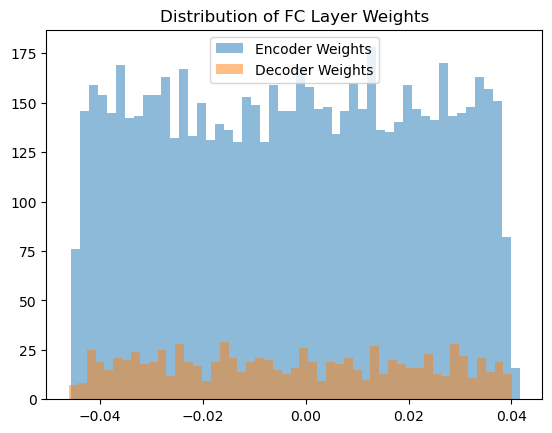

In [73]:
import matplotlib.pyplot as plt

plt.hist(encoder_weights.cpu().detach().numpy().flatten(), bins=50, alpha=0.5, label='Encoder Weights')
plt.hist(decoder_weights.cpu().detach().numpy().flatten(), bins=50, alpha=0.5, label='Decoder Weights')
plt.legend()
plt.title('Distribution of FC Layer Weights')
plt.show()